# Imports

In [45]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import sys
import time

import arviz as az
import jax
from jax import numpy as jnp
from jax.random import PRNGKey
import numpy as np
import pandas as pd
from optax import adam
import tensorflow_probability.substrates.jax.distributions as tfd


sys.path.append(os.path.abspath(".."))
from scripts.notebook_utils import (
    plot_elbo, 
    plot_true_predicted_comparison, 
    plot_regression_results, 
    plot_synthetic_data,
    plot_data,
    REGRESSION_COLORPALETTE,
    TRUEPARAM_COLORPALETTE,
    PREDPARAM_COLORPALETTE,
    ELBO_COLOR,
)
from scripts.vigamlss import (
    Normal, 
    DataPreparator, 
    DegenerateNormal, 
    FullCovarianceNormal, 
    HalfCauchy, 
    TransformationFunctions,
    CustomGPD
)

os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Save Dirs

In [46]:
pickle_dir = sys.path[-1] + "/results/gpd"
plot_dir = sys.path[-1] + "/plots/gpd"

# VIGAMLSS with GEV Response and PSplines

## Synthetic Data

### Preperations

#### Synthetic Data Creation

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/gpd_syn_data_overview.svg


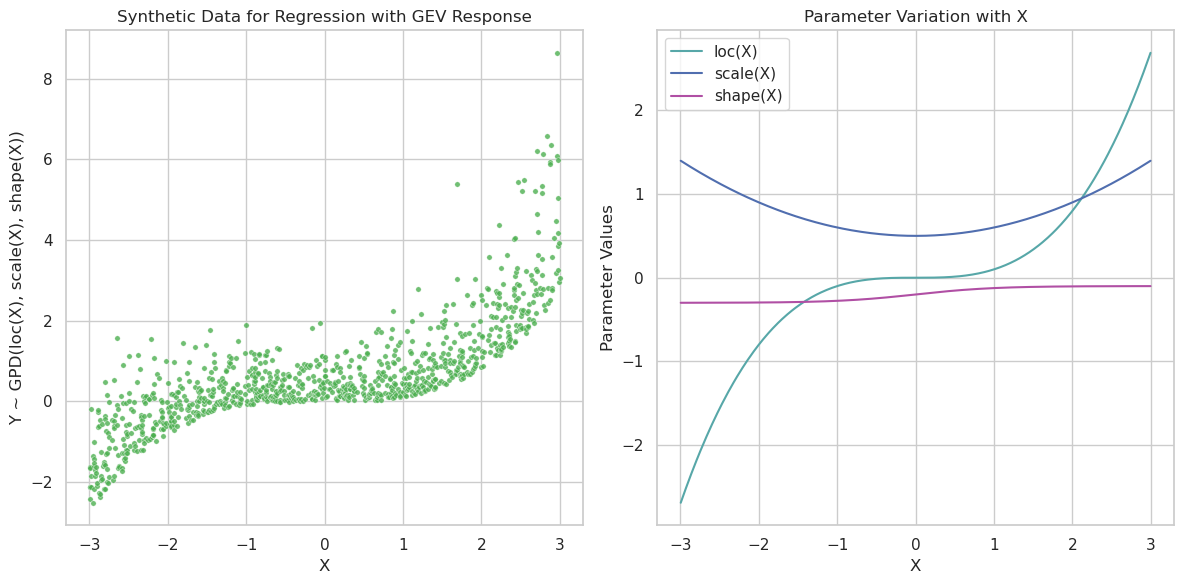

In [47]:
def vigamlss_gpd_create_syn_data():
    # ------------------------------------------------
    # 1) Generate covariate X
    # ------------------------------------------------
    key = PRNGKey(42)
    n_samples = 1000
    key_x, key_y = jax.random.split(key)
    X_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
    X_SYN   = jnp.sort(X_SYN)
    # ------------------------------------------------
    # 2) Define parametric functions for loc(x), scale(x), shape(x)
    # ------------------------------------------------
    def loc_fn(x):
        return 0.1 * x**3
    def scale_fn(x):
        return 0.1 * x**2 + 0.5
    def shape_fn(x):
        return 0.1 * jnp.tanh(x) - 0.2
    loc_vals   = loc_fn(X_SYN)
    scale_vals = scale_fn(X_SYN)
    shape_vals = shape_fn(X_SYN)
    # ------------------------------------------------
    # 3) Constructs a *batch* of GPDs, one per (x_i).
    #    TFP automatically enforces domain logic for each sample.
    # ------------------------------------------------
    gpd_dists = tfd.GeneralizedPareto(
        loc          = loc_vals,     # shape=(n_samples,)
        scale        = scale_vals,   # shape=(n_samples,)
        concentration= shape_vals    # shape=(n_samples,)
    )
    # ------------------------------------------------
    # 4) Sample Y given X
    # ------------------------------------------------
    Y_SYN = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
    Y_SYN = jnp.array(Y_SYN)

    plot_synthetic_data(
        X=X_SYN,
        Y=Y_SYN,
        scatterplot_color=REGRESSION_COLORPALETTE[0],
        line_palette=TRUEPARAM_COLORPALETTE,
        lines=[loc_vals, scale_vals, shape_vals],
        scatter_xlabel="X",
        scatter_ylabel="Y ~ GPD(loc(X), scale(X), shape(X))",
        scatter_title="Synthetic Data for Regression with GEV Response",
        line_xlabel="X",
        line_ylabel="Parameter Values",
        line_title="Parameter Variation with X",
        line_labels=["loc(X)","scale(X)","shape(X)"],
        file_name="gpd_syn_data_overview",
        save_dir=plot_dir,
    )

    return X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals

X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals = vigamlss_gpd_create_syn_data()

#### Data Preperation

In [48]:
def vigamlss_gpd_syn_data_prepare_data(X):
    DesignMatrix, K = DataPreparator(
        "DesignMatrix",
        X,
        "pspline",
        intercept=False,
        standardize=False,
        degree=3,
        num_knots=10,
    )()
    return DesignMatrix, K

#### Model Definition

In [49]:
def vigamlss_gpd_syn_data_define_model(DesignMatrix, Y, K):
    β0_loc = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
    γ_loc = DegenerateNormal("gammas_loc", K, λ_loc)

    β0_scale = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
    γ_scale = DegenerateNormal("gammas_scale", K, λ_scale)

    β0_shape = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
    λ_shape = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
    γ_shape = DegenerateNormal("gammas_shape", K, λ_shape)

    Y = CustomGPD(
        "y_CustomGPD",
        β0_loc + DesignMatrix @ γ_loc,
        β0_scale + DesignMatrix @ γ_scale,
        β0_shape + DesignMatrix @ γ_shape,
        responses=Y,
    )
    return Y

#### Optimization Run

In [53]:
def vigamlss_gpd_syn_data_opt_run(Y):
    start_time = time.time()
    results = Y.model.run_svi_optimization(
        optimizer=adam,
        vi_dist=FullCovarianceNormal,
        vi_sample_size=64,
        epochs=50000,
        mb_size=None,
        lr=0.001,
        max_norm=1.0,
        clip_min_max_enabled=True,
        zero_nans_enabled=True,
        prng_key=PRNGKey(0),
        scheduler_type="constant",
    )
    end_time = time.time()
    elapsed_seconds = end_time - start_time
    minutes, seconds = divmod(elapsed_seconds, 60)
    print(f"Elapsed time for optimization: {int(minutes)} min: {seconds:.2f} sec")
    with open(pickle_dir + "/results_syn_data.pickle", 'wb') as handle:
        pkl.dump(results, handle)
    return results

#### Results Aggregation

In [54]:
def vigamlss_gpd_syn_data_results(results, DesignMatrix, X, Y, loc_vals, scale_vals, shape_vals):
    β0_loc_opt = results["transformed_loc_vi_parameters"]["beta0_loc"]
    γ_loc_opt = results["transformed_loc_vi_parameters"]["gammas_loc"]
    β0_scale_opt = results["transformed_loc_vi_parameters"]["beta0_scale"]
    γ_scale_opt = results["transformed_loc_vi_parameters"]["gammas_scale"]
    β0_shape_opt = results["transformed_loc_vi_parameters"]["beta0_shape"]
    γ_shape_opt = results["transformed_loc_vi_parameters"]["gammas_shape"]

    linear_predictor_loc = β0_loc_opt + DesignMatrix.matrix @ γ_loc_opt
    linear_predictor_scale = TransformationFunctions.softplus(β0_scale_opt + DesignMatrix.matrix @ γ_scale_opt)
    linear_predictor_shape = β0_shape_opt + DesignMatrix.matrix @ γ_shape_opt

    gpd_dists = tfd.GeneralizedPareto(
        linear_predictor_loc, 
        linear_predictor_scale, 
        linear_predictor_shape
    )
    samples = gpd_dists.sample((100000,), PRNGKey(0))
    samples = np.array(samples)

    pred_mean_line = gpd_dists.mean()
    pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)
    pred_hdi_lower = pred_hdi_bounds[:, 0]
    pred_hdi_upper = pred_hdi_bounds[:, 1]

    plot_elbo(
        num_iterations=results["svi_metadata"]["num_iterations"],
        elbo_values=results["losses"],
        elbo_color=ELBO_COLOR,
        initial_percentage=0.1,
        final_percentage=0.8,
        save_dir=plot_dir,
        file_name="syn_data_elbo",
    )
    plot_regression_results(
        scatter_x=X,
        scatter_y=Y,
        x_pred=X,
        pred_mean=pred_mean_line,
        lower_hdi_bound=pred_hdi_lower,
        upper_hdi_bound=pred_hdi_upper,
        hdi_alpha=0.2,
        regression_colorpalette=REGRESSION_COLORPALETTE,
        scatter_label="Data Points",
        regression_label="Regression Line",
        hdi_label="95% HDI",
        xlabel="X",
        ylabel="Response",
        title="Bayesian P-Spline Regression for GPD Response with 95% HDI",
        save_dir=plot_dir,
        file_name="syn_data_regression_results"
    )
    plot_true_predicted_comparison(
        X=X,
        true_parameter_values=[loc_vals, scale_vals, shape_vals],
        predicted_parameter_values=[
            linear_predictor_loc, 
            linear_predictor_scale, 
            linear_predictor_shape
        ],
        true_palette=TRUEPARAM_COLORPALETTE,
        pred_palette=PREDPARAM_COLORPALETTE,
        line_labels=["Location", "Scale", "Shape"],
        title="Comparison of True vs. Predicted GPD Parameters",
        xlabel="X",
        ylabel="Parameter Value",
        save_dir=plot_dir,
        file_name="syn_data_true_pred_comp"
    )

### Conduct

Elapsed time for optimization: 0 min: 29.96 sec


/tmp/ipykernel_519743/1064553110.py:22: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi_bounds = az.hdi(samples, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_elbo.svg


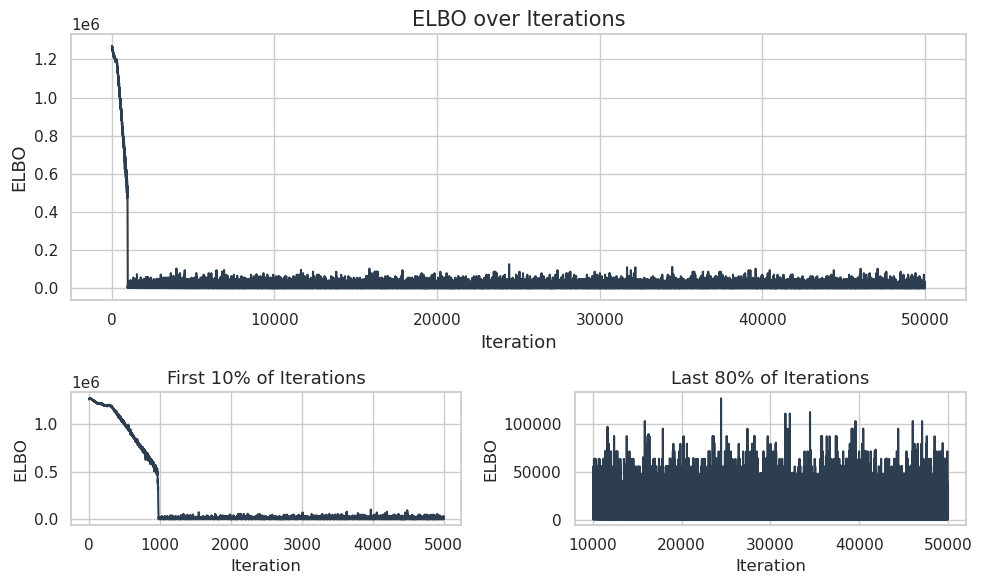

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_regression_results.svg


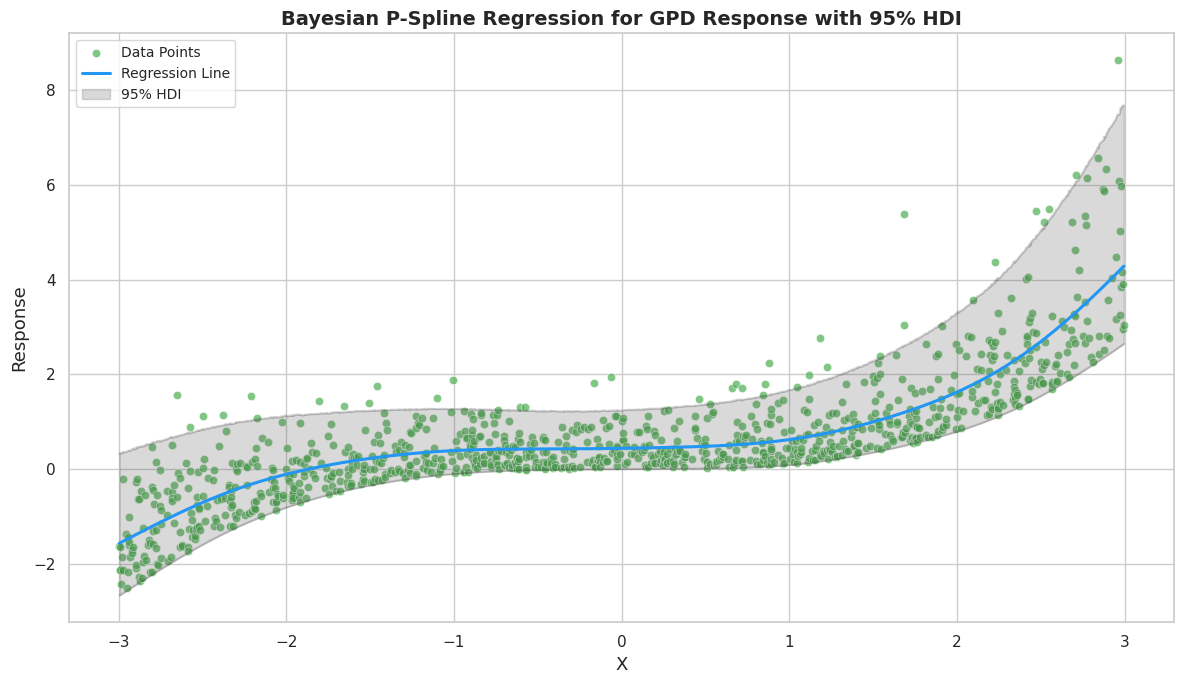

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/plots/gpd/syn_data_true_pred_comp.svg


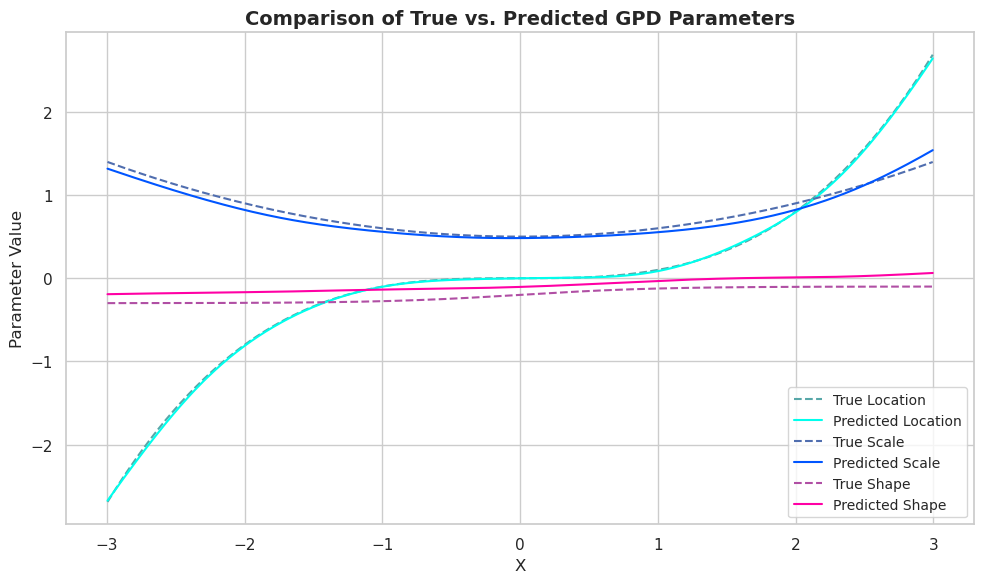

In [55]:
DesignMatrix, K = vigamlss_gpd_syn_data_prepare_data(X_SYN)
model = vigamlss_gpd_syn_data_define_model(DesignMatrix, Y_SYN, K)
results = vigamlss_gpd_syn_data_opt_run(model)
vigamlss_gpd_syn_data_results(results, DesignMatrix, X_SYN, Y_SYN, loc_vals, scale_vals, shape_vals)